# **Análisis de Sistemas Térmicos usando Python**

In [2]:
#pip install Coolprop

En este notebook se presenta un ejemplo de cómo usar Python para analizar los procesos internos de un Aire Acondicionado centralizado de un edificio. Se presenta un ejemplo considerando un sistema operando en un edificio y bajo condiciones climáticas de cundía caluroso y húmedo.

Partamos importando las librerías necesarias para trabajar.

In [3]:
import numpy as np
import CoolProp.CoolProp as cp
import matplotlib.pyplot as plt
from CoolProp.HumidAirProp import HAPropsSI
from pint import UnitRegistry

El ejemplo considera que el aire interior se acondiciona a $T_{in} =$ 24ºC y $\phi_{in} =$ 0.45. 

El edificio está sujeto a una carga térmica debido a la ganancia solar, la conducción y la infiltración de aire, así como a las cargas internas asociadas con diversas fuentes. La tasa total de transferencia de calor al edificio es  $\dot{Q}_b =$ 100kW. 

El aire del edificio también está sujeto a la adición de humedad por parte de los ocupantes y otras fuentes. 

La tasa total de adición de humedad al aire del edificio es $\dot{m}_{v,b} =$ 0.0115 kg/s. 

El aire exterior a una temperatura de $T_{out} =$ 30ºC y $\phi_{out} =$ 0.58 se introduce en el sistema a un caudal de $\dot{V}_{out} =$ 5100 cfm. 

Parte del aire de escape extraído del edificio se desvía y se mezcla con el aire exterior. 

La velocidad de flujo volumétrico del flujo de aire de retorno es $\dot{V}_{r} =$ 8200 cfm. 

El flujo de aire mixto pasa a través de una bobina de agua fría donde se enfría y deshumidifica, y luego a través de un serpentín por donde circula vapor, donde se recalienta. 

La presión es atmosférica en todo el sistema.

<img src="Class_16_AC.png" alt="Example" />

In [4]:
ureg = UnitRegistry()
ureg.default_format = '.3f'

# **a)** Determine la temperatura y la humedad relativa del aire que se proporciona al edificio en el estado 4.

In [5]:
#Presión en el sistema
P = (1 *ureg.atm).to('Pa') # Presión atmosférica en Pa

#Edificio
Q_dot_b = (ureg.Quantity(100, 'kW')).to('W') # Carga térmica del edificio
m_dot_b = (ureg.Quantity(0.0115, 'kg/s')).to('kg/s') # Carga de agua en el edificio (carga latente)

## Datos del aire externo  
T_amb = (ureg.Quantity(30, 'degC')).to('K') # Temperatura del aire externo
phi_amb = 0.58  # Humedad relativa del aire externo
V_dot_amb = (ureg.Quantity(5100, 'feet**3/minute')).to('m**3/s') # Caudal de aire externo 

## Datos del aire interno
T_in = (ureg.Quantity(24, 'degC')).to('K') # Temperatura del aire interno   
phi_in = 0.45  # Humedad relativa del aire interno
V_dot_r = (ureg.Quantity(8200, 'feet**3/minute')).to('m**3/s') # Caudal de aire de retorno

In [6]:
T = np.empty(5)*ureg.kelvin
h = np.empty(5)*ureg.joule/ureg.kilogram
v = np.empty(5)*ureg.meter**3/ureg.kilogram
phi,omega = np.empty(5),np.empty(5)

El estado del aire proveniente del exterior (estado 0), está determinado por la temperatura, $T_0 = T_{amb}$, y la humedad relativa, $\phi_0 = \phi_{amb}$. Se calculan la relación de humedad, la entalpía específica del aire seco y el volumen específico del aire seco ($\omega_0$, $h_{0}$ y $v_{0}$).

In [7]:
# Estado 0: Aire de externo

T[0] = T_amb
phi[0] = phi_amb
omega[0] = HAPropsSI('W', 'T', T[0].magnitude, 'R', phi[0], 'P', P.magnitude)
h[0] = HAPropsSI('H', 'T', T[0].magnitude, 'R', phi[0], 'P', P.magnitude)*ureg.joule/ureg.kilogram
v[0] = HAPropsSI('V', 'T', T[0].magnitude, 'R', phi[0], 'P', P.magnitude)*ureg.meter**3/ureg.kilogram

El flujo másico de aire retornado (recirculado) al sistema se determina:

$\dot{m}_{amb} = \frac{\dot{V}_{amb}}{v_{0}}$

In [8]:
m_dot_amb = V_dot_amb/v[0]
m_dot_amb

2.7352366839360274 <Unit('kilogram / second')>

El estado del aire que es retornado desde el efiticio (estado 1) está definido por la temperatura $T_{in} = T_1$ y la humedad relativa $\phi_{in}=\phi_1$. La humedad absoluta, entalpìa y volumen específico en el estado 1 ($h_1$, $v_1$ y $w_1$, respectivamente) son determinados a partir de dichas propiedades.

In [9]:
# Estado 1: Aire de retorno

T[1] = T_in
phi[1] = phi_in
omega[1] = HAPropsSI('W', 'T', T[1].magnitude, 'R', phi[1], 'P', P.magnitude)
h[1] = HAPropsSI('H', 'T', T[1].magnitude, 'R', phi[1], 'P', P.magnitude)*ureg.joule/ureg.kilogram
v[1] = HAPropsSI('V', 'T', T[1].magnitude, 'R', phi[1], 'P', P.magnitude)*ureg.meter**3/ureg.kilogram

El flujo másico de aire retornado (recirculado) al sistema se determina:

$\dot{m}_{r} = \frac{\dot{V}_r}{v_{1}}$

In [10]:
m_dot_r = V_dot_r/v[1]
m_dot_r 

4.537760332898475 <Unit('kilogram / second')>

Un balance de masa de aire seco en estado estacionario en el proceso de mezcla es:
$\dot{m}_{r} + \dot{m}_{amb} = \dot{m}_{a}$

donde $\dot{m}_{a}$ es el flujo másico de aire seco que pasa a través de los serpentines de agua fría y vapor.

Similarmente, aplicando un balance de masa de agua en el proceso de mezcla es posible determinar la relación de humedad del aire que ingresa al serpentín de agua fría. 

$\dot{m}_{r} \omega_1+ \dot{m}_{amb} \omega_0 = \dot{m}_{a} \omega_2$
 

Por otro lado, el balance de energía en estado estacionario en el proceso de mezcla adiabática se expresa como:

​$\dot{m}_{r} h_1+ \dot{m}_{amb} h_0 = \dot{m}_{a} h_2$
 
Desde esta expresión es posible determinar la entalpía específica del aire seco que ingresa al serpentín de agua fría. 

Así, el estado 2 está determinado por $\omega_2$ y $h_2$, luego es posible determinar la temperatura y la humedad relativa del aire en el estado 2

In [11]:
#Mezcla aire de retorne y aire externo  -> Estado 2
m_dot_a = m_dot_r + m_dot_amb                               #Balance de masa  
omega[2] = (m_dot_r*omega[1] + m_dot_amb*omega[0])/m_dot_a  #Balance de masa de agua
h[2] = (m_dot_r*h[1] + m_dot_amb*h[0])/m_dot_a              #Balance de energía

T[2] =  HAPropsSI('T', 'H', h[2].magnitude, 'W', omega[2], 'P', P.magnitude)*ureg.kelvin #Temperatura de la mezcla
phi[2] = HAPropsSI('R', 'H', h[2].magnitude, 'W', omega[2], 'P', P.magnitude) #Humedad relativa de la mezcla

Antes de determinar los estados intermedios, necesitamos determinar el estado del aire que ingresa al espacio climatizado, con tal de que se mantengan los malances de masa y energía en el sistema.

Así, aplicando un balance de masa de agua en el edificio se tiene: 

$\dot{m}_a \omega_4+ \dot{m}_{b} = \dot{m}_{a} \omega_1$

De dicha ecuación podemos determinar la humedad abosluta del aire entrando al espcio climatizado. Aplicando un balance de energía en el edificio se tiene:

​$\dot{m}_a h_4+ \dot{Q}_b = \dot{m}_a h_1$

Lo que nos permite determinar la entalpía específica del aire que ingresa al espacio climatizado. Así, el estado 4 queda determinado por $\omega_4$ y $h_4$, por lo que la temperatura $T_4$ y la humedad relativa $\phi_4$ pueden ser determinadas

In [12]:
# Estado 4: Ingreso de aire en el espacio climatizado
%precision %.2f
omega[4] = (m_dot_a*omega[1] - m_dot_b)/m_dot_a     #Balance de agua en el espacio climatizado
h[4] = (m_dot_a*h[1] - Q_dot_b)/m_dot_a             #Balance de energía en el espacio climatizado
T[4] =  HAPropsSI('T', 'H', h[4].magnitude, 'W', omega[4], 'P', P.magnitude)*ureg.kelvin #Temperatura del aire que ingresa en el espacio climatizado
phi[4] = HAPropsSI('R', 'H', h[4].magnitude, 'W', omega[4], 'P', P.magnitude) #Humedad relativa del aire que ingresa en el espacio climatizado

print("La temperatura del aire que ingresa en el espacio climatizado (Estado 4) es:", T[4].to('degC'),", mientras que la humedad relativa es:", '{:0.3f}'.format(phi[4]))

La temperatura del aire que ingresa en el espacio climatizado (Estado 4) es: 14.454 degree_Celsius , mientras que la humedad relativa es: 0.664


# **b)** Determine la tasa de transferencia de calor desde el aire al agua fria y la tasa de agua condensada en el serpentín de agua fría.

La humedad absoluta en el estado 4 debe ser igual a la humedad en el estado 5, dado que no se añade ni se elimina humedad en el serpentín de vapor. Así, $\omega_3 = \omega_4$. 

Dado que la humedad absoluta disminuye entre los estados 2 y y, el aire debe haber sido enfriado por debajo de la temperatura de punto de rocío en el estado 2 y debería salir del serpentín de agua fría en un estado saturado, $\phi_3 = 1$. 

Luego, el estado 3 queda determinado por $\omega_3$ y $\phi_3$. Por lo tanto, la temperatura y entalpía específica ($T_3$ y $h_3$)pueden ser determinadas.

In [13]:
#Estado 3
omega[3] = omega[4] #humedad absoluta
phi[3] = 1 #humedad relativa

T[3] = HAPropsSI('T', 'W', omega[3], 'R', phi[3], 'P', P.magnitude)*ureg.kelvin #Temperatura del aire a la salida del serpentín frio
h[3] = HAPropsSI('H', 'W', omega[3], 'R', phi[3], 'P', P.magnitude)*ureg.joule/ureg.kilogram #Entalpía del aire a la salida del serpentín frio

ValueError: Sorry, but cannot provide two inputs that are both water-content (humidity ratio, relative humidity, absolute humidity :: inputs were:"T","W",6.8124819028447048e-03,"R",1.0000000000000000e+00,"P",1.0132500000000000e+05 

In [14]:
DP_4 = HAPropsSI('D', 'T', T[4].magnitude, 'R', phi[4], 'P', P.magnitude)

#Estado 3
omega[3] = omega[4] #humedad absoluta
T[3] = DP_4*ureg.kelvin #Temperatura del aire a la salida del serpentín frio

phi[3] = HAPropsSI('R', 'T', T[3].magnitude, 'W', omega[3], 'P', P.magnitude) #Humedad relativa del aire a la salida del serpentín frio
h[3] = HAPropsSI('H', 'T', T[3].magnitude, 'W', omega[3], 'P', P.magnitude)*ureg.joule/ureg.kilogram #Entalpía del aire a la salida del serpentín frio

phi[3]

1.00

Aplicando un balance de masa en el serpentín de agua fría tenemos:

$\dot{m}_a \omega_2 = \dot{m}_c + \dot{m}_a \omega_3 $

donde $\dot{m}_c$ es la tasa de agua condensada en el serpentín de agua fría. El volumen específico del agua condensada, $v_c$, se determina asumiendo que el serpentín de agua fría opera a presión atmosférica. Luego, el caudal de agua condensada es:

$\dot{V}_c = \dot{m}_c v_c$

In [15]:
m_dot_c = m_dot_a * omega[2] - m_dot_a * omega[3] # Balance de masa de agua en el serpentín de enfriamiento
v_c = cp.PropsSI('V', 'T', T[3].magnitude, 'P', P.magnitude,'water' )*ureg.meter**3/ureg.kilogram # Volumen específico del agua condensada en el serpentín de enfriamiento

V_dot_c = m_dot_c * v_c # Caudal de agua condensada en el serpentín de enfriamiento
'{:0.3f}'.format(V_dot_c.to('L/min'))

'2.564 liter / minute'

Un balance de energía en el serpentín de agua fría se expresa como:

​$\dot{m}_a h_2 = \dot{m}_c h_c + \dot{Q}_{cw} = \dot{m}_a h_3$

donde $h_c$ es la entalpía específica del agua condensada (evaluada a $T_3$ y presión atmosférica) y $\dot{Q}_{cw}$ es la tasa de transferencia de calor desde el aire al agua fría.	

In [16]:
h_c = cp.PropsSI('H', 'T', T[3].magnitude, 'P', P.magnitude,'water' )*ureg.joule/ureg.kilogram # Entalpía específica del agua condensada en el serpentín de enfriamiento
Q_dot_cw = m_dot_a * h[2] - m_dot_a * h[3] - m_dot_c * h_c     # Balance de energía en el serpentín de enfriamiento

'{:0.3f}'.format(Q_dot_cw.to('kW'))

'211.577 kilowatt'

# **c)** Determine la tasa de transferencia de calor desde el serpentín de vapor al aire.

Aplicando un balance de energía en el serpentín de vapor se tiene:

​$\dot{m}_a h_3 + \dot{Q}_{sc} = \dot{m}_a h_4$

In [17]:
Q_dot_sc = m_dot_a * (h[4] - h[3]) # Balance de energía en el serpentín de calentamiento

'{:0.3f}'.format(Q_dot_sc.to('kW'))

'45.766 kilowatt'

Si graficamos todo en el diagrama psicrométrico podemos ver todos los procesos y estados del sistema.

In [28]:
from matplotlib.lines import Line2D

(0.00, 35.00)

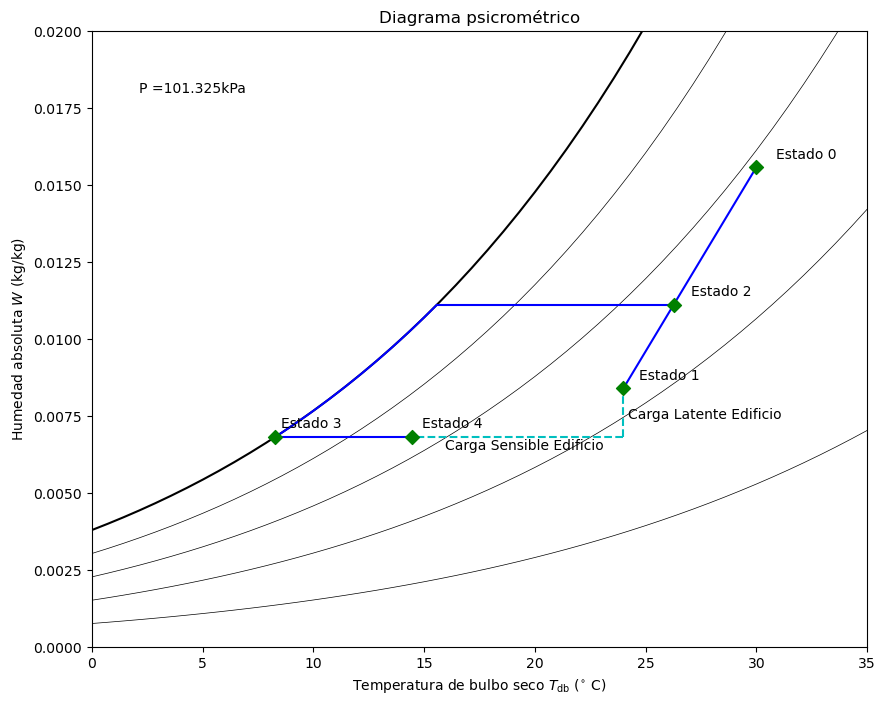

In [125]:
Pressure = P.magnitude# Pa 

fig, ax = plt.subplots(1,1,figsize=(10, 8))
Tdbvec = np.linspace(0, 35)+273.15

# Lines of constant relative humidity
for RH in np.arange(0.2, 1, 0.2):
    W = cp.HAPropsSI("W","R",RH,"P",Pressure,"T",Tdbvec)
    plt.plot(Tdbvec-273.15, W, color='k', lw = 0.5)

# Saturation curve
W = cp.HAPropsSI("W","R",1,"P",Pressure,"T",Tdbvec)
plt.plot(Tdbvec-273.15, W, color='k', lw=1.5)

ax.annotate('P =' + f'{Pressure/1000}' + 'kPa', xy=(2, 0.0175), xytext=(2.1,0.018))
    
# Puntos con los estado termodinámicos
e_h = 1.03 # Espaciamiento horizontal

line_01 = Line2D([T[0].to('degC').magnitude,T[1].to('degC').magnitude],[omega[0],omega[1]],color='b') # Linea que une los estados
ax.add_line(line_01)

T_aux = HAPropsSI('D', 'T', T[2].magnitude, 'W', omega[2], 'P', P.magnitude)
line_2a = Line2D([T[2].to('degC').magnitude,T_aux-273.15],[omega[2],omega[2]],color='b') # Linea que une los estados
ax.add_line(line_2a)

T_l_aux = np.linspace(T[3].magnitude, T_aux)
W_aux = cp.HAPropsSI("W","R",1,"P",Pressure,"T",T_l_aux)
plt.plot(T_l_aux-273.15, W_aux, color='b', lw=1.5)

line_34 = Line2D([T[3].to('degC').magnitude,T[4].to('degC').magnitude],[omega[3],omega[4]],color='b') # Linea que une los estados 
ax.add_line(line_34)

#Líneas Auxiliares
line_aux_1 = Line2D([T[1].to('degC').magnitude,T[4].to('degC').magnitude],[omega[4],omega[4]],color='c',linewidth=1.5,linestyle='dashed') # Linea que une los estados
ax.add_line(line_aux_1)
plt.annotate(f'Carga Sensible Edificio', ((T[4].magnitude-273.15)+1.5, omega[4]-0.0004))

line_aux_2 = Line2D([T[1].to('degC').magnitude,T[1].to('degC').magnitude],[omega[4],omega[1]],color='c',linewidth=1.5,linestyle='dashed') # Linea que une los estados
ax.add_line(line_aux_2)
plt.annotate(f'Carga Latente Edificio', ((T[1].magnitude-273.15)+0.2, omega[4]+0.0006))

for i in range(5):
    plt.scatter(T[i].magnitude-273.15, omega[i], c='g',s=50,zorder=5,marker='D') 
    plt.annotate(f'Estado {i}', ((T[i].magnitude-273.15)*e_h, omega[i]+0.0003))

plt.title('Diagrama psicrométrico')   
plt.xlabel(r'Temperatura de bulbo seco $T_{\rm db}$ ($^{\circ}$ C)')
plt.ylabel(r'Humedad absoluta $W$ (kg/kg)')
plt.ylim(0, 0.02)
plt.xlim(0, 35)